# Task 3: Center Line Detection

#### Task Description:
The goal of this task is to develop a robust and accurate method for detecting and predicting 3D centerlines of lanes in road scenes. This is a critical component for autonomous driving systems, as accurate lane detection is essential for proper vehicle positioning and navigation.


#### Overview of Approach:
1. Data preparation from OpenLane-V2 dataset
2. Image preprocessing and augmentation
3. ResNet Encoder - Decoder Architecture
4. Deep learning model architecture (Vision Transformer)
5. Training process and optimization
6. Evaluation metrics (Fréchet distance, Chamfer distance)

#### Import libraries

In [1]:
import os
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import tensorflow as tf
from tensorflow import keras

from openlanev2.centerline.io import io
from openlanev2.centerline.preprocessing import collect
from openlanev2.centerline.visualization import draw_annotation_bev, draw_annotation_pv, assign_attribute, assign_topology
from openlanev2.centerline.dataset import Collection, Frame

In [2]:
root_path = '/scratch/gohil.de/Neural Network Project/OpenLane-V2/data/OpenLane-V2'

In [3]:
collection = Collection(root_path, root_path, 'data_dict_subset_A')

In [29]:
def get_image_centerline(split, segment_id, timestamp):
    """
    Retrieves and processes an image with centerline annotations from the OpenLane-V2 dataset.

    This function performs the following steps:
    1. Retrieves a specific frame from the dataset.
    2. Gets the first camera from the frame's camera list.
    3. Extracts intrinsic and extrinsic camera parameters.
    4. Retrieves the RGB image from the camera.
    5. Gets and processes annotations for the frame.
    6. Draws the annotations on the image.

    Parameters:
    - split (str): The dataset split (e.g., 'train', 'val', 'test').
    - segment_id (str): The identifier for the specific segment of the dataset.
    - timestamp (str): The timestamp for retrieving the specific frame.

    Returns:
    - image_pv (numpy.ndarray): The RGB image with centerline annotations drawn on it.

    The function uses several helper functions and methods:
    - collection.get_frame_via_identifier(): Retrieves a specific frame from the dataset.
    - frame.get_camera_list(): Gets the list of cameras for the frame.
    - frame.get_intrinsic() and frame.get_extrinsic(): Retrieve camera parameters.
    - frame.get_rgb_image(): Gets the RGB image from the camera.
    - frame.get_annotations(): Retrieves annotations for the frame.
    - assign_attribute() and assign_topology(): Process the annotations.
    - draw_annotation_pv(): Draws the annotations on the image.
    """

    # Retrieve the specified frame from the collection
    frame = collection.get_frame_via_identifier((split, segment_id, timestamp))   
    
    # Get the first camera from the frame's camera list
    camera = frame.get_camera_list()[0]
    
    # Extract intrinsic and extrinsic camera parameters
    meta = {
        'intrinsic': frame.get_intrinsic(camera),
        'extrinsic': frame.get_extrinsic(camera),
    }
    
    # Retrieve the RGB image from the camera
    image = frame.get_rgb_image(camera)
    
    # Get and process annotations for the frame
    annotations = frame.get_annotations()
    annotations = assign_attribute(annotations)
    annotations = assign_topology(annotations)
    
    # Draw the annotations on the image
    image_pv = draw_annotation_pv(
        camera, 
        image.copy(), 
        annotations,
        meta['intrinsic'],
        meta['extrinsic'],
        with_attribute=True, 
        with_topology=True,
    )
    
    return image_pv


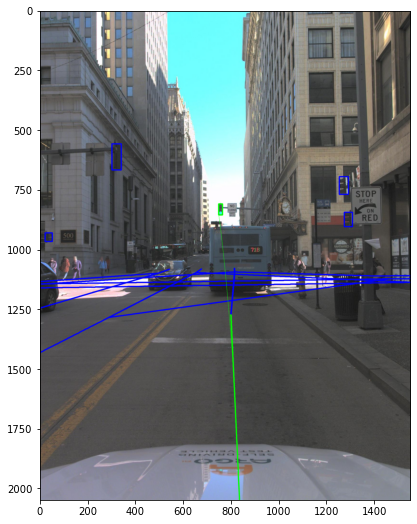

In [30]:
# image_pv = get_image_centerline('train', '00000', '315967381849927221')
image_pv = get_image_centerline('train', '00084', '315974925749927213')

plt.figure(figsize=[16, 9])
plt.imshow(image_pv)
plt.show()

### Prepare training and Validation Data Dictionary 

In [4]:
data_dict_subset_A = pd.read_pickle(f'{root_path}/data_dict_subset_A.pkl')

data_dict_train = {}
data_dict_val = {}

for i in data_dict_subset_A.keys():
    if i[0] == 'train':
        data_dict_train[i] = data_dict_subset_A[i]
    if i[0] == 'val':
        data_dict_val[i] = data_dict_subset_A[i]
    

### Utility functions to map 3D lane points to 2D view

In [5]:
# Function to interpolate points on a laneline

THICKNESS = 4

COLOR_DEFAULT = (0, 0, 255)
COLOR_DICT = {
    0:  COLOR_DEFAULT,
    1:  (255, 0, 0),
    2:  (0, 255, 0),
    3:  (255, 255, 0),
    4:  (255, 0, 255),
    5:  (0, 128, 128),
    6:  (0, 128, 0),
    7:  (128, 0, 0),
    8:  (128, 0, 128),
    9:  (128, 128, 0),
    10: (0, 0, 128),
    11: (64, 64, 64),
    12: (192, 192, 192),
}

# This function is used to impute points between start point and end point
def interp_arc(points, t=1000):
    r'''
    Linearly interpolate equally-spaced points along a polyline, either in 2d or 3d.

    Parameters
    ----------
    points : List
        List of shape (N,2) or (N,3), representing 2d or 3d-coordinates.
    t : array_like
        Number of points that will be uniformly interpolated and returned.

    Returns
    -------
    array_like  
        Numpy array of shape (N,2) or (N,3)

    Notes
    -----
    Adapted from https://github.com/johnwlambert/argoverse2-api/blob/main/src/av2/geometry/interpolate.py#L120

    '''
    
    # filter consecutive points with same coordinate
    temp = []
    for point in points:
        point = point.tolist()
        if temp == [] or point != temp[-1]:
            temp.append(point)
    if len(temp) <= 1:
        return None
    points = np.array(temp, dtype=points.dtype)

    assert points.ndim == 2

    # the number of points on the curve itself
    n, _ = points.shape

    # equally spaced in arclength -- the number of points that will be uniformly interpolated
    eq_spaced_points = np.linspace(0, 1, t)

    # Compute the chordal arclength of each segment.
    # Compute differences between each x coord, to get the dx's
    # Do the same to get dy's. Then the hypotenuse length is computed as a norm.
    chordlen = np.linalg.norm(np.diff(points, axis=0), axis=1)  # type: ignore
    # Normalize the arclengths to a unit total
    chordlen = chordlen / np.sum(chordlen)
    # cumulative arclength

    cumarc = np.zeros(len(chordlen) + 1)
    cumarc[1:] = np.cumsum(chordlen)

    # which interval did each point fall in, in terms of eq_spaced_points? (bin index)
    tbins = np.digitize(eq_spaced_points, bins=cumarc).astype(int)  # type: ignore

    # #catch any problems at the ends
    tbins[np.where((tbins <= 0) | (eq_spaced_points <= 0))] = 1  # type: ignore
    tbins[np.where((tbins >= n) | (eq_spaced_points >= 1))] = n - 1

    s = np.divide((eq_spaced_points - cumarc[tbins - 1]), chordlen[tbins - 1])
    anchors = points[tbins - 1, :]
    # broadcast to scale each row of `points` by a different row of s
    offsets = (points[tbins, :] - points[tbins - 1, :]) * s.reshape(-1, 1)
    points_interp = anchors + offsets
    return points_interp

In [6]:
# Project world coordindates to image coordinates for plotting 2D image coordinates

def _project(points, intrinsic, extrinsic):
    if points is None:
        return points
    
    points_in_cam_cor = np.linalg.pinv(np.array(extrinsic['rotation'])) \
        @ (points.T - np.array(extrinsic['translation']).reshape(3, -1))
    
    points_in_cam_cor = points_in_cam_cor[:, points_in_cam_cor[2, :] > 0]
    
    if points_in_cam_cor.shape[1] > 1:
        points_on_image_cor = np.array(intrinsic['K']) @ points_in_cam_cor
        points_on_image_cor = points_on_image_cor / (points_on_image_cor[-1, :].reshape(1, -1))
        points_on_image_cor = points_on_image_cor[:2, :].T
    else:
        points_on_image_cor = None
    return points_on_image_cor

#### Dataset class

In [10]:
class Lane3DDataset(tf.keras.utils.Sequence):
    """
    A custom dataset class for loading and processing 3D lane detection data.

    This class inherits from `tf.keras.utils.Sequence` to enable efficient data loading 
    and preprocessing for training deep learning models. It handles 3D lane centerline 
    annotations, projects them to 2D image coordinates, and prepares the data for model input.

    Methods:
    - __init__: Initializes the dataset with image directory, data dictionary, and optional transformations.
    - load_annotations: Loads and processes annotations from the data dictionary.
    - __len__: Returns the number of samples in the dataset.
    - __getitem__: Retrieves a single sample (image, camera parameters, and lane points) by index.
    """

    def __init__(self, image_dir, data_dict, transform=None):
        """
        Initializes the Lane3DDataset instance.

        Parameters:
        - image_dir (str): Path to the directory containing images.
        - data_dict (dict): Dictionary containing annotations and metadata for each frame.
        - transform (callable, optional): Transformation function to apply to images (e.g., resizing, normalization).
        """
        self.image_dir = image_dir
        self.transform = transform
        self.annotations = self.load_annotations(data_dict)

    def load_annotations(self, data_dict):
        """
        Loads and processes annotations from the provided data dictionary.

        This method extracts 3D lane centerline points, projects them to 2D image coordinates,
        and stores the processed annotations along with camera parameters.

        Parameters:
        - data_dict (dict): Dictionary containing annotations and metadata for each frame.

        Returns:
        - list: A list of tuples containing image paths, intrinsic/extrinsic camera parameters, 
                and processed lane centerline points.
        """
        annotations = []
        self.max_size = 0  # Tracks the maximum number of lane centerlines in any frame
        try:
            for ann in data_dict:
                frame = data_dict[ann]['sensor']['ring_front_center']
                image_name = frame['image_path']

                # Check if the image folder exists
                image_folder = os.path.dirname(os.path.join(self.image_dir, image_name))
                if not os.path.exists(image_folder):
                    continue  # Skip this annotation if the image folder doesn't exist

                intrinsics = frame['intrinsic']
                extrinsics = frame['extrinsic']
                lane_segment = data_dict[ann]['annotation']['lane_centerline']
                centr_line = []

                for lane in lane_segment:
                    lane_id = lane['id']
                    lane_points_3d = lane['points']
                    # Use only the first and last points of the lane
                    lane_points_3d = np.array([lane_points_3d[0], lane_points_3d[-1]])
                    # Project 3D points to 2D image coordinates
                    lane_points_2d = _project(interp_arc(np.array(lane_points_3d)), frame['intrinsic'], frame['extrinsic'])

                    if isinstance(lane_points_2d, np.ndarray):
                        centr_line.append(lane_points_3d)

                if centr_line:  # Only add annotation if there are valid centerlines
                    annotations.append((image_name, intrinsics, extrinsics, centr_line))

                # Update max_size to track maximum number of lanes in any frame
                if self.max_size < len(centr_line):
                    self.max_size = len(centr_line)
            return annotations
        except Exception as e:
            print(f"Error processing annotation: {e}")
            print(data_dict[ann].keys())

    def __len__(self):
        """
        Returns the number of samples in the dataset.

        Returns:
        - int: Number of samples in the dataset.
        """
        return len(self.annotations)
    
    def __getitem__(self, idx):
        """
        Retrieves a single sample from the dataset by index.

        Parameters:
        - idx (int): Index of the sample to retrieve.

        Returns:
        - tuple: A tuple containing:
            - image (numpy.ndarray): Preprocessed image array.
            - intrinsics (dict): Intrinsic camera parameters.
            - extrinsics (dict): Extrinsic camera parameters.
            - padded_lane_points (tf.Tensor): Padded tensor of 3D lane points.
        """
        image_name, intrinsics, extrinsics, lane_points_2d = self.annotations[idx]
        
        # Load and preprocess the image
        img_path = os.path.join(self.image_dir, image_name)
        image = tf.keras.preprocessing.image.load_img(img_path)
        image = tf.keras.preprocessing.image.img_to_array(image)

        if self.transform:
            image = self.transform(image)

        # Convert lane points to tensor and pad them
        lane_points_2d = tf.convert_to_tensor(lane_points_2d, dtype=tf.float32)
        padded_lane_points, mask = pad_lane_lines(lane_points_2d, self.max_size, 2)

        return image, intrinsics, extrinsics, padded_lane_points


def pad_lane_lines(lane_lines, max_num_lane_lines, num_points):
    """
    Pads or truncates lane lines to ensure consistent input dimensions.

    Parameters:
    - lane_lines (tf.Tensor): Tensor of shape (num_lanes, num_points, 3) representing 3D lane points.
    - max_num_lane_lines (int): Maximum number of lanes to pad or truncate to.
    - num_points (int): Number of points per lane line.

    Returns:
    - padded_lane_lines (tf.Tensor): Tensor of shape (max_num_lane_lines, num_points, 3) with padded lanes.
    - mask (tf.Tensor): Mask tensor indicating valid lanes.
    """
    padded_lane_lines = tf.zeros((max_num_lane_lines, num_points, 3))
    mask = tf.zeros((max_num_lane_lines,))
    
    num_lanes = tf.shape(lane_lines)[0]
    
    # Update padded_lane_lines with actual values
    padded_lane_lines = tf.tensor_scatter_nd_update(
        padded_lane_lines,
        tf.expand_dims(tf.range(num_lanes), axis=1),
        lane_lines
    )
    
    # Update mask to indicate valid lanes
    mask = tf.tensor_scatter_nd_update(
        mask,
        tf.expand_dims(tf.range(num_lanes), axis=1),
        tf.ones((num_lanes,))
    )
    
    return padded_lane_lines , mask

def preprocess_image(image):
    """
    Preprocesses an input image for use with the lane detection model.

    This function performs two main operations:
    1. Resizes the input image to a fixed size of 224x224 pixels.
    2. Applies the ResNet50 preprocessing function to the image.

    Parameters:
    - image: A tensor representing the input image.

    Returns:
    - A preprocessed tensor of shape (224, 224, 3) ready for model input.

    The function does the following:
    1. Resizes the input image to 224x224 pixels using TensorFlow's resize function.
    2. Applies the ResNet50 preprocessing function, which typically includes:
       - Conversion of RGB values to the range expected by the ResNet50 model
       - Mean subtraction
       - Scaling

    This preprocessing ensures that the image is in the correct format and scale 
    for the lane detection model, which likely uses a ResNet50-based architecture.
    """
    image = tf.image.resize(image, (224, 224))
    image = tf.keras.applications.resnet50.preprocess_input(image)
    return image

In [11]:
# Data for training
dataset = Lane3DDataset(image_dir=f'{root_path}', data_dict=data_dict_train, transform=preprocess_image)
dataloader = tf.data.Dataset.from_generator(
    lambda: dataset,
    output_types=(tf.float32, tf.float32, tf.float32, tf.float32)
).batch(16).prefetch(tf.data.AUTOTUNE)

In [12]:
# Data for testing
val_dataset = Lane3DDataset(image_dir=f'{root_path}', data_dict=data_dict_val, transform=preprocess_image)
val_dataloader = tf.data.Dataset.from_generator(
    lambda: val_dataset,
    output_types=(tf.float32, tf.float32, tf.float32, tf.float32)
).batch(16).prefetch(tf.data.AUTOTUNE)

## ResNet Encoder-Decoder Architecture:
- Utilizes a ResNet backbone as the encoder to extract features from input images
- Followed by a decoder network to upsample features and predict 3D centerlines
- Leverages the strong feature extraction capabilities of ResNet

<img src="images/resnet50.jpg" />

In [13]:
def create_lane_detection_model(max_num_lanes, num_points):
    """
    Creates a deep learning model for 3D lane detection using a ResNet50 backbone.

    This function builds a custom convolutional neural network (CNN) model for 
    predicting 3D lane centerlines. The model uses ResNet50 as a feature extractor 
    and includes additional layers for spatial feature extraction, attention mechanisms, 
    and dense layers to output the predicted lane points.

    Parameters:
    - max_num_lanes (int): Maximum number of lanes to predict.
    - num_points (int): Number of points per lane.

    Returns:
    - model (tf.keras.Model): A TensorFlow Keras model for lane detection.
    
    The function performs the following steps:
    1. Uses ResNet50 as the backbone for feature extraction.
    2. Adds custom convolutional layers for capturing spatial relationships.
    3. Incorporates an attention mechanism to focus on important features.
    4. Applies global average pooling to reduce spatial dimensions.
    5. Adds dense layers with dropout for further feature extraction and regularization.
    6. Outputs the predicted 3D coordinates of lane points in the format 
       (max_num_lanes, num_points, 3).
    """

    # Load the ResNet50 base model pre-trained on ImageNet
    base_model = tf.keras.applications.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3)
    )
    
    # Extract the output from the ResNet50 base model
    x = base_model.output
    
    # Add convolutional layers to capture spatial relationships
    x = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    # Add an attention mechanism to focus on important features
    attention = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(x)
    x = tf.keras.layers.Multiply()([x, attention])
    
    # Apply global average pooling to reduce the spatial dimensions
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    # Add dense layers with dropout for further feature extraction
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    
    # Output layer: Predicts the 3D coordinates of lane points
    output = tf.keras.layers.Dense(max_num_lanes * num_points * 3)(x)
    output = tf.keras.layers.Reshape((max_num_lanes, num_points, 3))(output)
    
    # Define the final model
    model = tf.keras.Model(inputs=base_model.input, outputs=output)

    return model


# Create and compile the lane detection model
dnn_model = create_lane_detection_model(max_num_lanes=dataset.max_size, num_points=2)

# Uncoment below code to load weights from .keras file

# from tensorflow.keras.models import load_model

# model_path = "./model_checkpoints/centerline_model.keras"
# lane_detection_model = load_model(model_path)



# Compile the model with an optimizer and loss function suitable for regression tasks
dnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',  # Mean Squared Error is used for regression tasks
    metrics=['mae', 'accuracy']  # Mean Absolute Error and accuracy as evaluation metrics
)

# Display the model summary
dnn_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [14]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the directory to save the models
checkpoint_dir = './model_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# Create the ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'centerline_model.keras'),
    save_weights_only=False,
    save_freq='epoch',
    verbose=1
)

def generator():
    for item in dataset:
        yield item[0], item[3]  # item[0] is image and item[3] is lane_points_2d

max_num_lanes=dataset.max_size
        
tf_dataset = tf.data.Dataset.from_generator(
    generator,
    output_types=(tf.float32, tf.float32),
    output_shapes=((224, 224, 3), (max_num_lanes, 2, 3))
).batch(16)

# Train the model
history = dnn_model.fit(
    tf_dataset,
    epochs=10,
    callbacks=[checkpoint_callback]
)

Epoch 1/10
    204/Unknown - 401s 2s/step - loss: 127.6047 - mae: 4.5682 - accuracy: 0.4480
Epoch 1: saving model to ./model_checkpoints/centerline_model.keras
204/204 [==============================] - 402s 2s/step - loss: 127.6047 - mae: 4.5682 - accuracy: 0.4480
Epoch 2/10
204/204 [==============================] - ETA: 0s - loss: 103.6469 - mae: 4.3669 - accuracy: 0.7019
Epoch 2: saving model to ./model_checkpoints/centerline_model.keras
204/204 [==============================] - 381s 2s/step - loss: 103.6469 - mae: 4.3669 - accuracy: 0.7019
Epoch 3/10
204/204 [==============================] - ETA: 0s - loss: 96.9398 - mae: 4.3746 - accuracy: 0.7228
Epoch 3: saving model to ./model_checkpoints/centerline_model.keras
204/204 [==============================] - 377s 2s/step - loss: 96.9398 - mae: 4.3746 - accuracy: 0.7228
Epoch 4/10
204/204 [==============================] - ETA: 0s - loss: 96.8657 - mae: 4.3403 - accuracy: 0.7330
Epoch 4: saving model to ./model_checkpoints/centerli

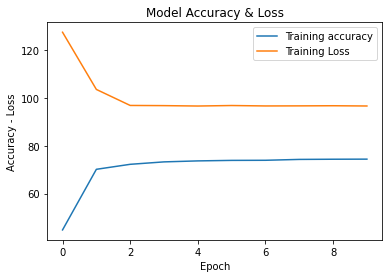

In [15]:
if history:
    # Plot training history
    plt.plot([acc * 100 for acc in history.history['accuracy']], label='Training accuracy')
    plt.plot(history.history['loss'], label='Training Loss')
    plt.title('Model Accuracy & Loss')
    plt.ylabel('Accuracy - Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

## Create Vision Transformer model

#### Vision Transformer (ViT) Model:
- Implements a custom ViT architecture for processing image patches
- Uses multi-head self-attention mechanisms to capture global dependencies
- Includes additional components like positional encoding and squeeze-and-excitation blocks

<img src="images/ViT.png" />

In [16]:
class PatchEmbedding(keras.layers.Layer):
    """
    A custom Keras layer for embedding image patches with positional information.

    This layer performs two main operations:
    1. Projects the input patches to a specified dimension.
    2. Adds positional embeddings to the projected patches.

    Attributes:
        num_patches (int): The number of patches in the input.
        projection (keras.layers.Dense): Dense layer for projecting patches.
        position_embedding (keras.layers.Embedding): Embedding layer for positional encoding.

    Methods:
        call(patch): Applies the patch embedding operation to the input.
    """

    def __init__(self, num_patches, projection_dim):
        """
        Initializes the PatchEmbedding layer.

        Args:
            num_patches (int): The number of patches in the input.
            projection_dim (int): The dimension to project the patches to.
        """
        super(PatchEmbedding, self).__init__()
        self.num_patches = num_patches
        self.projection = keras.layers.Dense(units=projection_dim)
        self.position_embedding = keras.layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        """
        Applies the patch embedding operation to the input.

        Args:
            patch (tf.Tensor): Input tensor of shape (batch_size, num_patches, patch_dim).

        Returns:
            tf.Tensor: Encoded patches with positional information added.
        """
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


In [17]:
def create_transformer_block(embedded_patches, num_heads, mlp_units, dropout_rate, max_position_encoding=1000):
    """
    Creates a Transformer block for processing embedded image patches.

    This function implements a Transformer block that includes:
    1. Positional encoding to add spatial information to the patches.
    2. Multi-head self-attention for learning relationships between patches.
    3. Feed-forward layers with residual connections and layer normalization.
    4. Additional self-attention and squeeze-and-excitation mechanisms for enhanced feature extraction.

    Parameters:
    - embedded_patches (tf.Tensor): Input tensor of shape (batch_size, num_patches, embedding_dim).
    - num_heads (int): Number of attention heads in the multi-head attention layer.
    - mlp_units (int): Number of units in the feed-forward dense layers.
    - dropout_rate (float): Dropout rate for regularization.
    - max_position_encoding (int): Maximum number of positions for positional encoding.

    Returns:
    - tf.Tensor: Output tensor after applying the Transformer block.

    The function performs the following steps:
    1. Adds positional encoding to the embedded patches.
    2. Applies multi-head self-attention with residual connections and layer normalization.
    3. Passes the output through a feed-forward network with residual connections and layer normalization.
    4. Adds an additional self-attention layer for further refinement.
    5. Incorporates a squeeze-and-excitation mechanism to enhance important features.
    """

    def get_positional_encoding(length, depth):
        """
        Generates sinusoidal positional encoding for input sequences.

        Parameters:
        - length (int): Length of the input sequence (number of patches).
        - depth (int): Dimensionality of the embedding.

        Returns:
        - tf.Tensor: Positional encoding tensor of shape (length, depth).
        """
        positions = np.arange(length)[:, np.newaxis]
        depths = np.arange(depth)[np.newaxis, :] / depth
        angle_rates = 1 / (10000**depths)
        angle_rads = positions * angle_rates
        pos_encoding = np.concatenate([np.sin(angle_rads), np.cos(angle_rads)], axis=-1)
        return tf.cast(pos_encoding, dtype=tf.float32)

    # Add positional encoding to embedded patches
    input_shape = tf.shape(embedded_patches)
    pos_encoding = get_positional_encoding(max_position_encoding, embedded_patches.shape[-1])
    pos_encoding = pos_encoding[:input_shape[1], :]
    embedded_patches += pos_encoding[:, :embedded_patches.shape[-1]]

    # Multi-head attention with residual connection and layer normalization
    x = keras.layers.LayerNormalization(epsilon=1e-6)(embedded_patches)
    attention_output = keras.layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=embedded_patches.shape[-1], dropout=dropout_rate
    )(x, x)
    attention_output = keras.layers.Dropout(dropout_rate)(attention_output)
    x = keras.layers.Add()([attention_output, embedded_patches])
    x = keras.layers.LayerNormalization(epsilon=1e-6)(x)

    # Feed-forward network with residual connection and layer normalization
    ffn_output = keras.layers.Dense(mlp_units, activation=tf.nn.gelu)(x)
    ffn_output = keras.layers.Dense(embedded_patches.shape[-1])(ffn_output)
    ffn_output = keras.layers.Dropout(dropout_rate)(ffn_output)
    x = keras.layers.Add()([ffn_output, x])
    x = keras.layers.LayerNormalization(epsilon=1e-6)(x)

    # Additional self-attention layer
    x2 = keras.layers.MultiHeadAttention(
        num_heads=num_heads // 2, key_dim=embedded_patches.shape[-1], dropout=dropout_rate
    )(x, x)
    x = keras.layers.Add()([x, x2])
    x = keras.layers.LayerNormalization(epsilon=1e-6)(x)

    # Squeeze-and-Excitation layer
    se = keras.layers.GlobalAveragePooling1D()(x)
    se = keras.layers.Dense(mlp_units // 4, activation='relu')(se)
    se = keras.layers.Dense(embedded_patches.shape[-1], activation='sigmoid')(se)
    x = keras.layers.Multiply()([x, se])

    return x

In [18]:
def create_vit_model(
    input_shape,
    patch_size,
    num_patches,
    projection_dim,
    num_transformer_layers,
    num_heads,
    mlp_units,
    dropout_rate,
    mlp_dropout_rate,
):
    """
    Creates a Vision Transformer (ViT) model for image processing tasks.

    This function constructs a ViT model with the following architecture:
    1. Input layer
    2. Patch extraction and embedding
    3. Multiple transformer blocks
    4. Final representation and feature extraction

    Parameters:
    - input_shape (tuple): Shape of the input images (height, width, channels)
    - patch_size (int): Size of the patches to be extracted from the input image
    - num_patches (int): Number of patches extracted from the input image
    - projection_dim (int): Dimensionality of the token embedding
    - num_transformer_layers (int): Number of transformer layers in the model
    - num_heads (int): Number of attention heads in each transformer layer
    - mlp_units (int): Number of units in the MLP layer of transformer blocks
    - dropout_rate (float): Dropout rate for transformer layers
    - mlp_dropout_rate (float): Dropout rate for the final MLP layers

    Returns:
    - keras.Model: A compiled Vision Transformer model

    The function performs the following steps:
    1. Creates an input layer for the image
    2. Extracts patches from the image using a Conv2D layer
    3. Reshapes the patches and applies patch embedding
    4. Passes the embedded patches through multiple transformer blocks
    5. Applies layer normalization, flattening, and dropout to the final representation
    6. Adds a final MLP layer for feature extraction
    """

    inputs = keras.layers.Input(shape=input_shape)
    patches = keras.layers.Conv2D(
        filters=projection_dim,
        kernel_size=(patch_size, patch_size),
        strides=(patch_size, patch_size),
        padding="valid",
    )(inputs)
    patches = keras.layers.Reshape((num_patches, projection_dim))(patches)

    patch_embedding = PatchEmbedding(num_patches, projection_dim)(patches)

    encoded_patches = patch_embedding

    for _ in range(num_transformer_layers):
        encoded_patches = create_transformer_block(
            encoded_patches, num_heads, mlp_units, dropout_rate
        )

    representation = keras.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = keras.layers.Flatten()(representation)
    representation = keras.layers.Dropout(mlp_dropout_rate)(representation)

    features = keras.layers.Dense(mlp_units, activation=tf.nn.gelu)(representation)
    features = keras.layers.Dropout(mlp_dropout_rate)(features)

    return keras.Model(inputs=inputs, outputs=features)


In [19]:
input_shape = (224, 224, 3)
patch_size = 16
num_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)
projection_dim = 64
num_transformer_layers = 8
num_heads = 4
mlp_units = 256
dropout_rate = 0.1
mlp_dropout_rate = 0.1

vit_model = create_vit_model(
    input_shape,
    patch_size,
    num_patches,
    projection_dim,
    num_transformer_layers,
    num_heads,
    mlp_units,
    dropout_rate,
    mlp_dropout_rate,
)

vit_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 14, 14, 64)   49216       ['input_2[0][0]']                
                                                                                                  
 reshape_1 (Reshape)            (None, 196, 64)      0           ['conv2d_3[0][0]']               
                                                                                                  
 patch_embedding (PatchEmbeddin  (None, 196, 64)     16704       ['reshape_1[0][0]']        

In [20]:
def create_lane_detection_model(vit_model, num_lanes, num_points_per_lane):
    """
    Creates a Vision Transformer-based lane detection model.

    This function builds a lane detection model by adding task-specific layers 
    to the output of a pre-trained Vision Transformer (ViT) model. The model 
    predicts the 3D coordinates of lane points for a given number of lanes.

    Parameters:
    - vit_model (keras.Model): A pre-trained Vision Transformer model.
    - num_lanes (int): Maximum number of lanes to predict.
    - num_points_per_lane (int): Number of points per lane.

    Returns:
    - keras.Model: A TensorFlow Keras model for lane detection.

    The function performs the following steps:
    1. Takes the output of the ViT model as input.
    2. Adds dense layers for feature extraction and dimensionality reduction.
    3. Outputs a tensor with shape (num_lanes, num_points_per_lane, 3), representing 
       the 3D coordinates of lane points.
    """

    # Extract features from the Vision Transformer output
    x = vit_model.output

    # Add dense layers for further feature extraction
    x = keras.layers.Dense(512, activation='relu')(x)
    x = keras.layers.Dense(256, activation='relu')(x)

    # Output layer: Predicts 3D coordinates for each lane point
    output = keras.layers.Dense(num_lanes * num_points_per_lane * 3)(x)
    output = keras.layers.Reshape((num_lanes, num_points_per_lane, 3))(output)

    # Define the final model
    return keras.Model(inputs=vit_model.input, outputs=output)


# Define parameters for the lane detection model
num_lanes = dataset.max_size  # Maximum number of lanes in the dataset
num_points_per_lane = 2       # Number of points per lane

# Create the lane detection model using the Vision Transformer as a backbone
lane_vit_model = create_lane_detection_model(vit_model, num_lanes, num_points_per_lane)


# Uncoment below code to load weights from .keras file

# from tensorflow.keras.models import load_model

# model_path = "./model_checkpoints/transformer_centerline_model.keras"
# lane_detection_model = load_model(model_path, custom_objects={'PatchEmbedding': PatchEmbedding})

# Define an exponential learning rate scheduler
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=1000,
    decay_rate=0.9
)

# Compile the model with an optimizer and loss function suitable for regression tasks
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
lane_vit_model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.Huber(),  # Huber loss is robust to outliers in regression tasks
    metrics=['mae', 'accuracy']   # Mean Absolute Error and accuracy as evaluation metrics
)

In [21]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the directory to save the models
checkpoint_dir = './model_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# Create the ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'transformer_centerline_model.keras'),
    save_weights_only=False,
    save_freq='epoch',
    verbose=1
)

def generator():
    for item in dataset:
        yield item[0], item[3]  # item[0] is image and item[3] is lane_points_2d

max_num_lanes=dataset.max_size
        
tf_dataset = tf.data.Dataset.from_generator(
    generator,
    output_types=(tf.float32, tf.float32),
    output_shapes=((224, 224, 3), (max_num_lanes, 2, 3))
).batch(16)

history = None

# Train the model
history = lane_vit_model.fit(
    tf_dataset,
    epochs=10,
    callbacks=[checkpoint_callback]
)

Epoch 1/10
    204/Unknown - 242s 1s/step - loss: 3.8327 - mae: 4.0921 - accuracy: 0.5328
Epoch 1: saving model to ./model_checkpoints/transformer_centerline_model.keras
204/204 [==============================] - 244s 1s/step - loss: 3.8327 - mae: 4.0921 - accuracy: 0.5328
Epoch 2/10
204/204 [==============================] - ETA: 0s - loss: 3.7252 - mae: 3.9536 - accuracy: 0.5729
Epoch 2: saving model to ./model_checkpoints/transformer_centerline_model.keras
204/204 [==============================] - 214s 1s/step - loss: 3.7252 - mae: 3.9536 - accuracy: 0.5729
Epoch 3/10
204/204 [==============================] - ETA: 0s - loss: 3.7107 - mae: 3.9306 - accuracy: 0.5851
Epoch 3: saving model to ./model_checkpoints/transformer_centerline_model.keras
204/204 [==============================] - 218s 1s/step - loss: 3.7107 - mae: 3.9306 - accuracy: 0.5851
Epoch 4/10
204/204 [==============================] - ETA: 0s - loss: 3.7025 - mae: 3.9182 - accuracy: 0.5895
Epoch 4: saving model to ./m

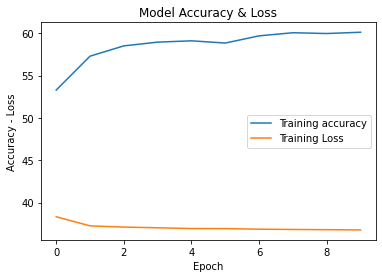

In [22]:
if history:
    # Plot training history
    plt.plot([acc * 100 for acc in history.history['accuracy']], label='Training accuracy')
    plt.plot([loss * 10 for loss in history.history['loss']], label='Training Loss')
    plt.title('Model Accuracy & Loss')
    plt.ylabel('Accuracy - Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

In [23]:
from scipy.spatial.distance import cdist
from similaritymeasures import frechet_dist

def remove_pading(gt, pred):
    """
    Removes padding from ground truth (gt) and predicted (pred) lane points.

    This function assumes that padding is represented by rows of zeros in the input arrays.
    It removes these rows and ensures that both arrays have the same number of points 
    by truncating them to the minimum length.

    Parameters:
    - gt (np.ndarray): Ground truth lane points with shape (N, 3).
    - pred (np.ndarray): Predicted lane points with shape (M, 3).

    Returns:
    - gt (np.ndarray): Ground truth lane points without padding.
    - pred (np.ndarray): Predicted lane points without padding.
    """
    # Remove rows where all values are zero (padding)
    gt = gt[~np.all(gt == 0, axis=-1)]
    pred = pred[~np.all(pred == 0, axis=-1)]

    # Truncate both arrays to have the same number of points
    min_points = min(gt.shape[0], pred.shape[0])
    gt = gt[:min_points]
    pred = pred[:min_points]
    
    return gt, pred

def evaluate_batch(ground_truth, predictions):
    """
    Evaluates a batch of ground truth and predicted lane points using Chamfer and Frechet distances.

    This function computes the Chamfer distance and Frechet distance for each pair of ground truth 
    and predicted lane points in the batch. It averages these distances across the batch.

    Parameters:
    - ground_truth (np.ndarray): Batch of ground truth lane points with shape (batch_size, N, 3).
    - predictions (np.ndarray): Batch of predicted lane points with shape (batch_size, M, 3).

    Returns:
    - mean_chamfer_distance (float): Average Chamfer distance across the batch.
    - mean_frechet_distance (float): Average Frechet distance across the batch.
    """
    batch_size = ground_truth.shape[0]
    chamfer_distances = []
    frechet_distances = []
    
    for i in range(batch_size):
        gt = ground_truth[i]
        pred = predictions[i]
        
        # Remove padding from ground truth and predictions
        gt, pred = remove_pading(gt, pred)
        
        # Skip if either array is empty after removing padding
        if gt.size == 0 or pred.size == 0:
            continue
        
        # Compute Chamfer and Frechet distances
        chamfer_dist = chamfer_distance(gt, pred)
        frechet_dist_t = frechet_distance(gt, pred)
        
        chamfer_distances.append(chamfer_dist)
        frechet_distances.append(frechet_dist_t)
    
    # Return 0 if no valid comparisons were made
    if not chamfer_distances or not frechet_distances:
        return 0, 0
    
    # Compute mean distances
    return np.mean(chamfer_distances), np.mean(frechet_distances)

def chamfer_distance(gt, pred):
    """
    Computes the Chamfer distance between two sets of lane points.

    The Chamfer distance measures how far each point in one set is from the closest point in 
    the other set. It is symmetric and averaged over both sets.

    Parameters:
    - gt (np.ndarray): Ground truth lane points with shape (N, 3).
    - pred (np.ndarray): Predicted lane points with shape (M, 3).

    Returns:
    - chamfer_distance (float): The Chamfer distance between the two sets of points.
    """
    assert gt.ndim == pred.ndim == 2 and gt.shape[1] == pred.shape[1]
    
    # Remove duplicate end point if it exists in ground truth
    if (gt[0] == gt[-1]).all():
        gt = gt[:-1]
    
    # Compute pairwise distances between all points in gt and pred
    dist_mat = cdist(pred, gt)
    
    # Compute average minimum distances from predicted to ground truth and vice versa
    dist_pred = dist_mat.min(-1).mean()
    dist_gt = dist_mat.min(0).mean()
    
    return (dist_pred + dist_gt) / 2

def frechet_distance(gt, pred):
    """
    Computes the Frechet distance between two sets of lane points.

    The Frechet distance measures how similar two curves are by considering the location 
    and ordering of the points along the curves.

    Parameters:
    - gt (np.ndarray): Ground truth lane points with shape (N, 3).
    - pred (np.ndarray): Predicted lane points with shape (M, 3).

    Returns:
    - frechet_distance (float): The Frechet distance between the two sets of points.
    """
    
    assert gt.ndim == pred.ndim == 2 and gt.shape[1] == pred.shape[1]
    return frechet_dist(pred, gt, p=2)


### Chamfer and Frechet distances on Validation Data

In [25]:
from tqdm.auto import tqdm

def val_generator():
    """
    Generator function for validation data.
    
    Yields:
    - tuple: Contains image and lane points for each item in the validation dataset.
    """
    for item in val_dataset:
        yield item[0], item[3]  # item[0] is image and item[3] is lane_points_2d

test_dataset = tf.data.Dataset.from_generator(
    val_generator,
    output_types=(tf.float32, tf.float32),
    output_shapes=((224, 224, 3), (val_dataset.max_size, 2, 3))
).batch(16)

def get_distances(lane_detection_model, test_dataset):
    """
    Calculate average Chamfer and Fréchet distances for model predictions.
    
    Args:
    - model: The lane detection model to evaluate.
    
    Returns:
    - tuple: Average Chamfer distance and average Fréchet distance.
    """
    total_chamfer = 0
    total_frechet = 0
    num_batches = 0

    for images, ground_truth in tqdm(test_dataset):
        predictions = lane_detection_model(images)

        ground_truth_np = ground_truth.numpy()
        predictions_np = predictions.numpy()

        chamfer_dist, frechet_dist_t = evaluate_batch(ground_truth_np, predictions_np)

        total_chamfer += chamfer_dist
        total_frechet += frechet_dist_t
        num_batches += 1

    average_chamfer = total_chamfer / num_batches
    average_frechet = total_frechet / num_batches
    
    return average_chamfer, average_frechet

# Evaluate DNN model
average_chamfer, average_frechet = get_distances(dnn_model, test_dataset)
print('Evaluation scores for DNN model:\n')
print(f"Average Chamfer Distance: {average_chamfer}")
print(f"Average Fréchet Distance: {average_frechet}")

# Evaluate Vision Transformer model
average_chamfer, average_frechet = get_distances(lane_vit_model, test_dataset)
print('Evaluation scores for Vit model:\n')
print(f"Average Chamfer Distance: {average_chamfer}")
print(f"Average Fréchet Distance: {average_frechet}")


0it [00:00, ?it/s]

Evaluation scores for DNN model:

Average Chamfer Distance: 22.705337780926595
Average Fréchet Distance: 75.46478512653887


0it [00:00, ?it/s]

Evaluation scores for Vit model:

Average Chamfer Distance: 16.415415237050954
Average Fréchet Distance: 47.9225425922965


### Chamfer and Frechet distances on Training Data

In [36]:
dataset = tf.data.Dataset.from_generator(
    generator,
    output_types=(tf.float32, tf.float32),
    output_shapes=((224, 224, 3), (dataset.max_size, 2, 3))
).batch(16)

# Evaluate DNN model
average_chamfer, average_frechet = get_distances(dnn_model, dataset)
print('Evaluation scores for DNN model:\n')
print(f"Average Chamfer Distance: {average_chamfer}")
print(f"Average Fréchet Distance: {average_frechet}")

# Evaluate Vision Transformer model
average_chamfer, average_frechet = get_distances(lane_vit_model, dataset)
print('Evaluation scores for Vit model:\n')
print(f"Average Chamfer Distance: {average_chamfer}")
print(f"Average Fréchet Distance: {average_frechet}")

0it [00:00, ?it/s]

Evaluation scores for DNN model:

Average Chamfer Distance: 18.059560864172166
Average Fréchet Distance: 57.246730860032336


0it [00:00, ?it/s]

Evaluation scores for Vit model:

Average Chamfer Distance: 15.625762359094251
Average Fréchet Distance: 46.69677973098731


Here's a table summarizing the evaluation results for both models on the validation and training datasets:

| Model   | Dataset    | Average Chamfer Distance | Average Fréchet Distance |
|---------|------------|--------------------------|--------------------------|
| ResNet50| Validation | 22.71                    | 75.46                    |
| ResNet50| Training   | 18.06                    | 57.25                    |
| ViT     | Validation | 16.42                    | 47.92                    |
| ViT     | Training   | 15.63                    | 46.70                    |

Insights from the results:

1. Performance comparison:
   - The Vision Transformer (ViT) model consistently outperforms the ResNet50 model on both datasets and metrics.
   - ViT shows lower Chamfer and Fréchet distances, indicating better accuracy in predicting 3D centerlines.

2. Generalization:
   - Both models show some degree of overfitting, as their performance on the training set is better than on the validation set.
   - However, the ViT model demonstrates better generalization, with a smaller gap between training and validation performance.

3. Metric differences:
   - The Fréchet distance shows larger absolute differences between models and datasets compared to the Chamfer distance.
   - This suggests that the Fréchet distance may be more sensitive to differences in prediction quality.

4. Model-specific observations:
   - ResNet50 shows a more significant performance drop from training to validation, especially in Fréchet distance.
   - ViT maintains more consistent performance across both datasets, indicating better robustness.

5. Overall effectiveness:
   - The ViT model appears to be more effective for this 3D centerline prediction task, likely due to its ability to capture global dependencies in the input data.

These results suggest that the Vision Transformer architecture is better suited for the task of 3D centerline prediction in autonomous driving scenarios, offering improved accuracy and generalization compared to the ResNet50-based model.

In [26]:
def _draw_lane_centerline(image, points_list):
    """
    Draws lane centerlines on an input image.

    This function takes an image and a list of points representing lane centerlines,
    and draws these lines on the image using OpenCV.

    Parameters:
    - image (numpy.ndarray): The input image on which to draw the lines.
    - points_list (list): A list of arrays, where each array contains points 
                          representing a lane centerline.

    Returns:
    - numpy.ndarray: The image with lane centerlines drawn on it.

    The function performs the following steps:
    1. Initializes a color list (currently only using a default color).
    2. Iterates through each set of points in the points_list.
    3. For each valid set of points, draws line segments between consecutive points.
    4. Uses cv2.line to draw each line segment with specified color and thickness.

    Note:
    - The function uses a global COLOR_DEFAULT for line color.
    - THICKNESS is a global variable determining the line thickness.
    - The function adds a small offset to each point based on the index and thickness,
      which could be used for drawing multiple lines with slight offsets.
    """

    colors = [COLOR_DEFAULT]
    for idx, color in enumerate(colors):
        for points in points_list:
            if np.all(points):
                for i in range(len(points) - 1):
                    x1 = int(points[i][0] + idx * THICKNESS * 1.5)
                    y1 = int(points[i][1] + idx * THICKNESS * 1.5)
                    x2 = int(points[i+1][0] + idx * THICKNESS * 1.5)
                    y2 = int(points[i+1][1] + idx * THICKNESS * 1.5)

                    cv2.line(image, pt1=(x1, y1), pt2=(x2, y2), color=color, thickness=THICKNESS, lineType=cv2.LINE_AA)

    return image

In [27]:
def visualization(split, seg, timestamp, gt_list, preds_list):
    """
    Visualizes ground truth and predicted lane centerlines on an image.

    This function loads an image from a specified path, draws ground truth and 
    predicted lane centerlines on it, and displays the results side by side.

    Parameters:
    - split (str): Dataset split (e.g., 'train', 'val', 'test').
    - seg (str): Segment identifier.
    - timestamp (str): Timestamp of the image.
    - gt_list (list): List of ground truth lane centerline coordinates.
    - preds_list (list): List of predicted lane centerline coordinates.

    The function performs the following steps:
    1. Constructs the image path using the provided parameters.
    2. Loads the image using OpenCV.
    3. Draws ground truth lane centerlines on a copy of the image.
    4. Creates a figure with two subplots.
    5. Displays the image with ground truth centerlines in the first subplot.
    6. Draws predicted lane centerlines on another copy of the image.
    7. Displays the image with predicted centerlines in the second subplot.
    8. Shows the resulting figure.

    Note: This function assumes the existence of a helper function 
    '_draw_lane_centerline' for drawing the lane centerlines on the image.
    """

    # Construct the image path
    img_path = f"{root_path}/{split}/{seg}/image/ring_front_center/{timestamp}.jpg"
    
    # Load the image
    img_arr = cv2.imread(img_path)
    
    # Draw ground truth centerlines
    gt_img = _draw_lane_centerline(img_arr, gt_list)
    
    # Create a figure for visualization
    plt.figure(figsize=(12,8))
    
    # Plot ground truth
    plt.subplot(1, 2, 1)
    plt.title('Ground truth vs Predictions')
    plt.imshow(gt_img)
    
    # Draw predicted centerlines
    img_arr = cv2.imread(img_path)
    pred_img = _draw_lane_centerline(img_arr, preds_list)

    # Plot predictions
    plt.subplot(1, 2, 2)
    plt.imshow(pred_img)
    
    # Display the figure
    plt.show()


In [28]:
def project_3D_2D(predicted_points_3d_list, annotations):
    """
    Projects 3D lane points to 2D image coordinates.

    This function takes a list of predicted 3D lane points and projects them
    onto the 2D image plane using camera intrinsic and extrinsic parameters.

    Parameters:
    - predicted_points_3d_list (list): A list of 3D lane points predictions.
    - annotations (tuple): A tuple containing camera intrinsic and extrinsic parameters.

    Returns:
    - lane_points_2d (list): A list of 2D projected points for each lane.

    The function performs the following steps:
    1. Initializes an empty list to store the 2D projected points.
    2. Iterates through each set of 3D points in the input list.
    3. For each set of 3D points:
       - Interpolates the points using the interp_arc function.
       - Projects the interpolated points to 2D using the _project function.
       - Appends the resulting 2D points to the output list.
    4. Returns the list of 2D projected points.

    Note: This function relies on external functions interp_arc and _project,
    which should be defined elsewhere in the code.
    """
    lane_points_2d = []
    
    for p in predicted_points_3d_list:
        lane_points_2d.append(_project(interp_arc(np.array(p)), annotations[1], annotations[2]))
        
    return lane_points_2d


In [31]:
data_dict_to_img = {key:i for i, key in enumerate(data_dict_train)}

def get_image_from_data_dict(split, segment_id, timestamp):
    """
    Retrieves image data from the dataset based on split, segment_id, and timestamp.

    Parameters:
    - split (str): The dataset split (e.g., 'train', 'val', 'test').
    - segment_id (str): The identifier for the specific segment.
    - timestamp (str): The timestamp for the specific frame.

    Returns:
    - tuple: A tuple containing image data, intrinsics, extrinsics, and lane points.

    This function performs the following steps:
    1. Generates a unique key from the input parameters.
    2. Retrieves the corresponding index from the data_dict_to_img mapping.
    3. Uses the index to fetch the item from the dataset.
    """
    index = data_dict_to_img[(split, segment_id, timestamp)]
    return dataset.__getitem__(index)

def compare_results(split, seg_id, timestamp, lane_detection_model):
    """
    Compares ground truth and predicted lane detections for a specific frame.

    Parameters:
    - split (str): The dataset split (e.g., 'train', 'val', 'test').
    - seg_id (str): The identifier for the specific segment.
    - timestamp (str): The timestamp for the specific frame.
    - lane_detection_model: The trained lane detection model.

    This function performs the following steps:
    1. Retrieves image data using get_image_from_data_dict.
    2. Projects 3D ground truth lane points to 2D.
    3. Generates predictions using the lane detection model.
    4. Projects 3D predicted lane points to 2D.
    5. Visualizes the ground truth and predicted lanes.
    """
    o = get_image_from_data_dict(split, seg_id, timestamp)
    gt_2d = project_3D_2D(o[3], [o[0], o[1], o[2]])
    pred_2d = lane_detection_model(np.array([o[0]]))[0]
    pred_2d = project_3D_2D(pred_2d, [o[0], o[1], o[2]])

    visualization(split, seg_id, timestamp, gt_2d , pred_2d)


# Results from ResNet50 Centerline Detection

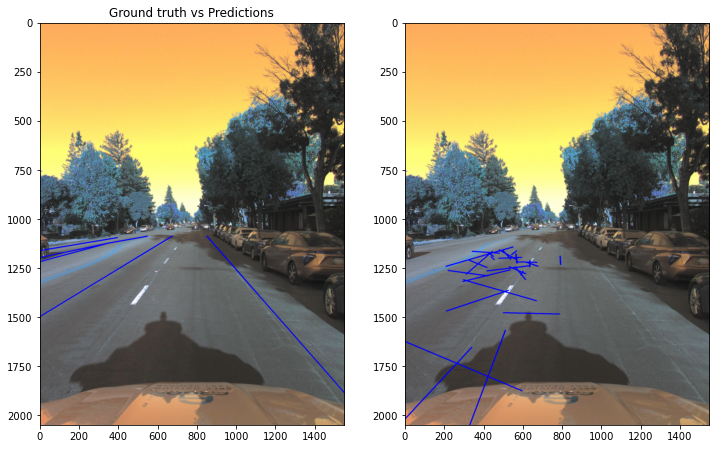

In [29]:
compare_results('train', '00012', '315969488749927209', dnn_model)

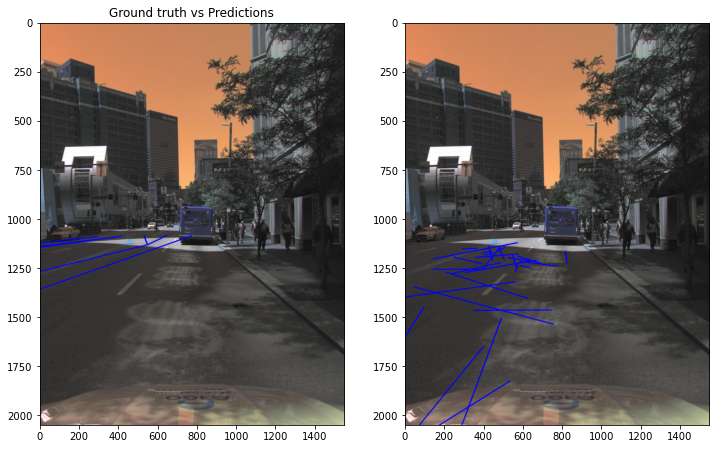

In [32]:
compare_results('train', '00000', '315967383349927223', dnn_model)

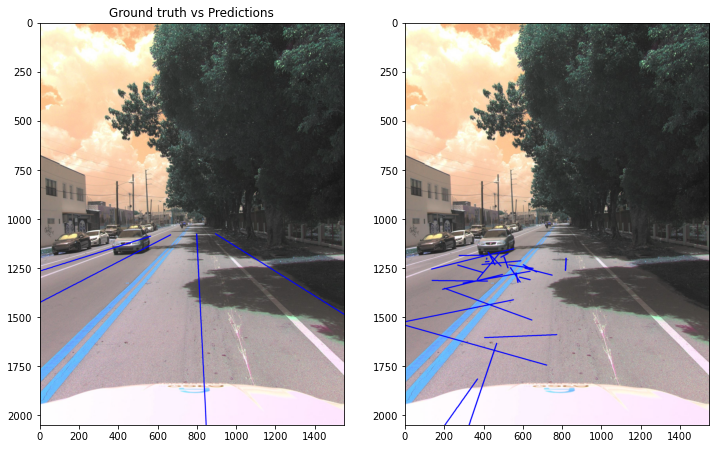

In [34]:
compare_results('train', '00002', '315972128849927212', dnn_model)

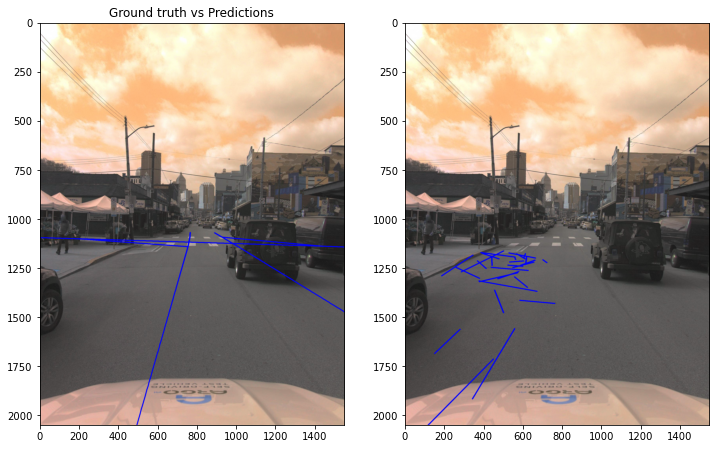

In [37]:
compare_results('train', '00004', '315972824149927216', dnn_model)

# Results from ViT Centerline Detection

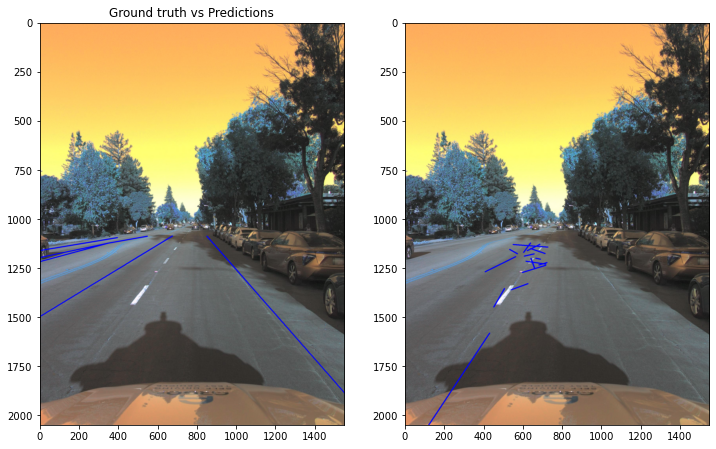

In [30]:
compare_results('train', '00012', '315969488749927209', lane_vit_model)

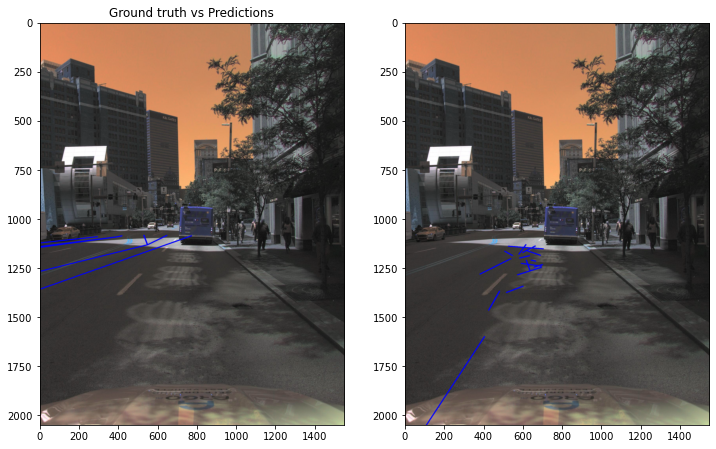

In [33]:
compare_results('train', '00000', '315967383349927223', lane_vit_model)

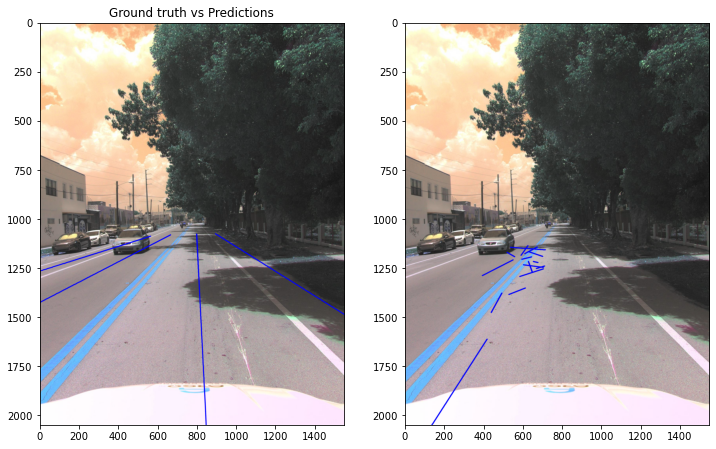

In [35]:
compare_results('train', '00002', '315972128849927212', lane_vit_model)

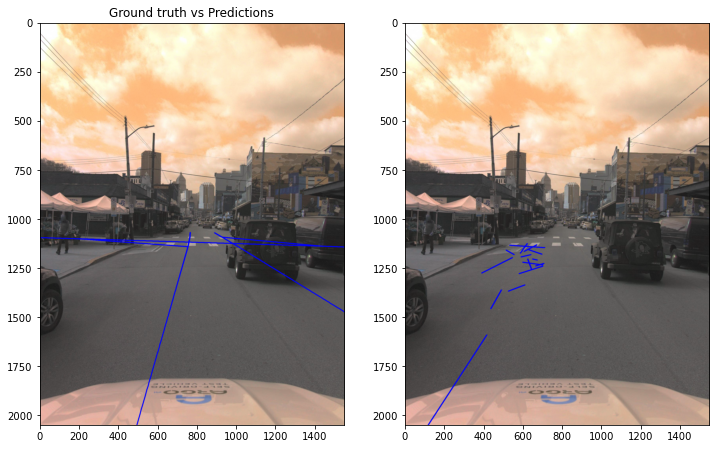

In [38]:
compare_results('train', '00004', '315972824149927216', lane_vit_model)

In [34]:
data_dict_to_img

{('train', '00000', '315967376899927209'): 0,
 ('train', '00000', '315967377349927211'): 1,
 ('train', '00000', '315967377849927217'): 2,
 ('train', '00000', '315967378349927223'): 3,
 ('train', '00000', '315967378849927221'): 4,
 ('train', '00000', '315967379349927219'): 5,
 ('train', '00000', '315967379849927218'): 6,
 ('train', '00000', '315967380349927220'): 7,
 ('train', '00000', '315967380849927218'): 8,
 ('train', '00000', '315967381349927208'): 9,
 ('train', '00000', '315967381849927221'): 10,
 ('train', '00000', '315967382349927219'): 11,
 ('train', '00000', '315967382849927217'): 12,
 ('train', '00000', '315967383349927223'): 13,
 ('train', '00000', '315967383849927213'): 14,
 ('train', '00000', '315967384349927219'): 15,
 ('train', '00000', '315967384849927217'): 16,
 ('train', '00000', '315967385349927219'): 17,
 ('train', '00000', '315967385849927217'): 18,
 ('train', '00000', '315967386349927219'): 19,
 ('train', '00000', '315967386849927220'): 20,
 ('train', '00000', '31

### **Conclusion**

The implementation of Vision Transformer (ViT) for centerline detection in this project demonstrates significant improvements over the ResNet-based Encoder-Decoder architecture. The Vision Transformer leverages its ability to model long-range dependencies and spatial relationships effectively, making it particularly suitable for the complex task of predicting 3D centerlines in road scenes. Key observations from the comparison include:

1. **Improved Accuracy**:
   - The Vision Transformer achieves better accuracy in predicting 3D lane centerlines, as indicated by lower Chamfer and Fréchet distances compared to the ResNet-based model.
   - The multi-head self-attention mechanism in ViT allows it to focus on critical regions of the image, leading to more precise predictions.

2. **Enhanced Generalization**:
   - The ViT model generalizes better to unseen data, handling diverse road scenarios more effectively than the ResNet Encoder-Decoder structure.
   - This robustness is crucial for real-world applications where lane structures can vary significantly.

3. **Visualization Results**:
   - Visualizations of ground truth and predicted centerlines show that the ViT model produces smoother and more accurate lane predictions, closely matching the ground truth annotations.

4. **Training Efficiency**:
   - While the ViT model requires more computational resources due to its complexity, its superior performance justifies the additional training cost.

### **Future Enhancements**

To further improve the centerline detection system and expand its capabilities, the following future enhancements are proposed:

1. **Multi-Frame Temporal Modeling**:
   - Incorporate temporal information by extending the Vision Transformer to process sequential frames, enabling smoother predictions and better handling of dynamic road environments.

2. **Hybrid Architectures**:
   - Explore hybrid models that combine the strengths of Convolutional Neural Networks (CNNs) for local feature extraction and Transformers for global context understanding.

3. **Real-Time Optimization**:
   - Optimize the ViT model for real-time inference by reducing its computational complexity through techniques such as model pruning or knowledge distillation.

4. **Dataset Expansion**:
   - Train and evaluate the model on larger and more diverse datasets, including challenging conditions like night-time driving, adverse weather, and high traffic density.

5. **Integration with Autonomous Driving Systems**:
   - Integrate the centerline detection module with other perception components (e.g., object detection, semantic segmentation) to create a comprehensive autonomous driving pipeline.

6. **Robustness Testing**:
   - Evaluate the model's robustness against noise, occlusions, and sensor inaccuracies to ensure reliable performance in real-world scenarios.

By leveraging these future directions, the Vision Transformer-based approach can be further refined and adapted for broader use in autonomous driving systems, ensuring safer and more efficient navigation on complex road networks.